In [1]:
%ls
%run DataAndEnvironment.ipynb

Cameras.ipynb      DataAndEnvironment.ipynb  nerv.py              setup.py*
collected_env.txt  data.py                   nerv_transformer.py  VolRen.ipynb
collect_env.py*    model.py                  __pycache__/
cub-1.16.0/        nerp.py                   README.md
data@              nerv_enlarge_cam.py       requirements.txt


/data/qtran/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1593
['data/ChestXRLungSegmentation/Imagenglab/processed/train/images/001.nii.gz']
23389
['data/ChestXRLungSegmentation/VinDr/v1/processed/train/images/000434271f63a053c4128a0ba6352c7f.png']
1593
['data/ChestXRLungSegmentation/Imagenglab/processed/train/images/001.nii.gz']
5077
['data/ChestXRLungSegmentation/VinDr/v1/processed/test/images/002a34c58c5b758217ed1f584ccbcfe9.png']
1593
['data/ChestXRLungSegmentation/Imagenglab/processed/train/images/001.nii.gz']
5077
['data/ChestXRLungSegmentation/VinDr/v1/processed/test/images/002a34c58c5b758217ed1f584ccbcfe9.png']


In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
cameras = RandomCameras(batch_size=hparams.batch_size, random=True).to(device)

# render_size describes the size of both sides of the 
# rendered images in pixels. We set this to the same size
# as the target images. I.e. we render at the same
# size as the ground truth images.
render_size = hparams.shape

# Our rendered scene is centered around (0,0,0) 
# and is enclosed inside a bounding box
# whose side is roughly equal to 3.0 (world units).
volume_extent_world = 4.0

# 1) Instantiate the raysampler.
# Here, NDCMultinomialRaysampler generates a rectangular image
# grid of rays whose coordinates follow the PyTorch3D
# coordinate conventions.
# Since we use a volume of size 128^3, we sample n_pts_per_ray=150,
# which roughly corresponds to a one ray-point per voxel.
# We further set the min_depth=0.1 since there is no surface within
# 0.1 units of any camera plane.
raysampler = NDCMultinomialRaysampler(
    image_width=render_size,
    image_height=render_size,
    n_pts_per_ray=256,
    min_depth=0.001,
    max_depth=volume_extent_world,
)


# 2) Instantiate the raymarcher.
# Here, we use the standard EmissionAbsorptionRaymarcher 
# which marches along each ray in order to render
# each ray into a single 3D color vector 
# and an opacity scalar.
def _shifted_cumprod(x, shift=1):
    """
    Computes `torch.cumprod(x, dim=-1)` and prepends `shift` number of
    ones and removes `shift` trailing elements to/from the last dimension
    of the result.
    """
    x_cumprod = torch.cumprod(x, dim=-1)
    x_cumprod_shift = torch.cat(
        [torch.ones_like(x_cumprod[..., :shift]), x_cumprod[..., :-shift]], dim=-1
    )
    return x_cumprod_shift


class EmissionAbsorptionRaymarcherBackToFront(EmissionAbsorptionRaymarcher):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def forward(
        self,
        rays_densities: torch.Tensor,
        rays_features: torch.Tensor,
        eps: float = 1e-10,
        **kwargs,
    ) -> torch.Tensor:
        rays_densities = rays_densities[..., 0]
        # print(rays_densities.shape)
        # absorption = _shifted_cumprod(
        #     (1.0 + eps) - rays_densities, shift=self.surface_thickness
        # )
        # weights = rays_densities * absorption
        # features = (weights[..., None] * rays_features).sum(dim=-2)
        # opacities = 1.0 - torch.prod(1.0 - rays_densities, dim=-1, keepdim=True)
        absorption = _shifted_cumprod(
            (1.0 + eps) - rays_densities, shift=self.surface_thickness
        )
        weights = rays_densities * absorption
        features = (weights[..., None] * rays_features).sum(dim=-2)
        opacities = 1.0 - torch.prod(1.0 - rays_densities, dim=-1, keepdim=True)
        return torch.cat((features, opacities), dim=-1)

class EmissionAbsorptionRaymarcherFrontToBack(EmissionAbsorptionRaymarcher):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def forward(
        self,
        rays_densities: torch.Tensor,
        rays_features: torch.Tensor,
        eps: float = 1e-10,
        **kwargs,
    ) -> torch.Tensor:
        rays_densities = rays_densities[..., 0]
        # print(rays_densities.shape)
        # absorption = _shifted_cumprod(
        #     (1.0 + eps) - rays_densities, shift=self.surface_thickness
        # )
        # weights = rays_densities * absorption
        # features = (weights[..., None] * rays_features).sum(dim=-2)
        # opacities = 1.0 - torch.prod(1.0 - rays_densities, dim=-1, keepdim=True)
        absorption = _shifted_cumprod(
            (1.0 + eps) - rays_densities.flip(dims=(-1,)), shift=self.surface_thickness
        ).flip(dims=(-1,))
        weights = rays_densities * absorption
        features = (weights[..., None] * rays_features).sum(dim=-2)
        opacities = 1.0 - torch.prod(1.0 - rays_densities, dim=-1, keepdim=True)
        return torch.cat((features, opacities), dim=-1)

raymarcher = EmissionAbsorptionRaymarcherFrontToBack()

# Finally, instantiate the volumetric render
# with the raysampler and raymarcher objects.
renderer = VolumeRenderer(
    raysampler=raysampler, 
    raymarcher=raymarcher,
)

# Instantiate the volumetric model.
volume_size = hparams.shape
volume_model = VolumeModel(
    renderer,
    volume_size = [volume_size] * 3, 
    voxel_size = volume_extent_world / volume_size,
).to(device)


debug_data = first(datamodule.train_dataloader())
image3d = debug_data['image3d'].to(device)
volumes = Volumes(
    features = torch.cat([image3d]*3, dim=1),
    densities = torch.ones_like(image3d) / 200., 
    voxel_size = volume_extent_world / volume_size,
)

DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.


In [3]:
screens = volume_model(cameras=cameras, volumes=volumes)

In [4]:
# print(cameras.get_buffer())

(-0.5, 255.5, 255.5, -0.5)

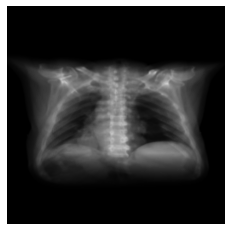

In [5]:
plt.imshow(screens[0,0,:,:].detach().cpu().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)
plt.axis('off')

In [6]:
vars(cameras)

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 'device': device(type='cuda', index=1),
 '_N': 4,
 'K': None,
 'znear': tensor([0.1000, 0.1000, 0.1000, 0.1000], device='cuda:1'),
 'zfar': tensor([3.5000, 3.5000, 3.5000, 3.5000], device='cuda:1'),
 'aspect_ratio': tensor([1.3395, 1.0637, 1.1623, 1.3358], device='cuda:1'),
 'fov': tensor([56.6907, 69.0218, 60.9811, 59.7274], device='cuda:1'),
 'R': tensor([[[-0.9993,  0.0027,  0.0372],
          [ 0.0000,  0.9974, -0.0720],
          [-0.0373, -0.0719, -0.9967]],
 
         [[-0.9993,  0.0027,  0.0372],
          [ 0.0000,  0.9974, -0.0720],
          [-0.0373, -0.0719, -0.996

In [7]:
cameras.get_camera_center()

tensor([[-0.1117,  0.2159,  2.9901],
        [-0.1117,  0.2159,  2.9901],
        [-0.1117,  0.2159,  2.9901],
        [-0.1117,  0.2159,  2.9901]], device='cuda:1')